# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

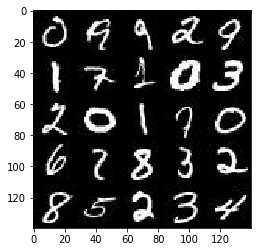

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

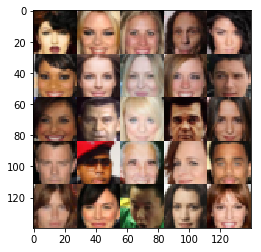

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels))
    input_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim))
    learn_rate = tf.placeholder(dtype=tf.float32)
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, is_training=True):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope("discriminator", reuse=reuse):
        
        # input: 28 * 28 * num_channels    
        x1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=5, strides=2, activation=None, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)

        # input: 14 * 14 * 64   
        x2 = tf.layers.conv2d(inputs=x1, filters=128, kernel_size=5, strides=2, activation=None, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_training,  )
        x2 = tf.maximum(alpha * x2, x2 )

        # input: 7 * 7 * 128    
        x3 = tf.layers.conv2d(inputs=x2, filters=256, kernel_size=5, strides=2, activation=None, padding='same')
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_training)
        x3 = tf.maximum(alpha * x3, x3)

        # input: 4 * 4 * 256
        x4 = tf.reshape(tensor=x3, shape=(-1, 4*4*256))
        
        # input: 4096
        logits = tf.layers.dense(inputs=x4, units=1, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)

        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [27]:
def generator(z, out_channel_dim, reuse=False, alpha=0.2, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    with tf.variable_scope("generator", reuse=reuse):
        
        # connect random input z to a dense layer
        x1 = tf.layers.dense(inputs=z, units=7*7*512, activation=None,  kernel_initializer=tf.contrib.layers.xavier_initializer())

        # apply batch normalization and leaky relu activation
        x2 = tf.reshape(x1, shape=(-1, 7, 7, 512))
        x2 = tf.layers.batch_normalization(inputs=x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        # input: 7*7*512 
        x3 = tf.layers.conv2d_transpose(inputs=x2, filters=256, activation=None, kernel_size=5, strides=2, padding='same',  kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(inputs=x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # output: 14 * 14 * 256
        
        # input: 14 * 14 * 256 
        x4 = tf.layers.conv2d_transpose(inputs=x3, filters=128, activation=None, kernel_size=5, strides=1, padding='same',  kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(inputs=x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # output: 14 * 14 * 128

        # input: 14 * 14 * 128 
        x5 = tf.layers.conv2d_transpose(inputs=x4, filters=out_channel_dim, activation=None, kernel_size=5, strides=2, padding='same',  kernel_initializer=tf.contrib.layers.xavier_initializer())
        # output: 28 * 28 * color_channels

        # rescale output using tanh
        g_model = tf.tanh(x5)
        
        return g_model


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [28]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(z = input_z, out_channel_dim=out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(images=input_real)
    d_model_fake, d_logits_fake = discriminator(images=g_model, reuse=True)
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [29]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    all_vars = [v for v in tf.trainable_variables() ]
    print("all vars found: ",len(all_vars))
    
    g_vars = [v for v in all_vars if v.name.startswith('generator')]
    print("generator vars found: ",len(g_vars), ": ", [g.name for g in g_vars])
    
    d_vars = [v for v in all_vars if v.name.startswith('discriminator')]
    print("discriminator vars found: ", len(d_vars), ": ", [d.name for d in d_vars])
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
        return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

all vars found:  2
generator vars found:  1 :  ['generator/Variable:0']
discriminator vars found:  1 :  ['discriminator/Variable:0']
Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, reuse=True, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """


    input_real_ph, input_z_ph, learn_rate_ph = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)    
    d_loss, g_loss = model_loss(input_real=input_real_ph, input_z=input_z_ph, out_channel_dim=data_shape[3])    
    d_opt, g_opt = model_opt(d_loss=d_loss, g_loss=g_loss, learning_rate=learn_rate_ph, beta1=beta1)
    
    show_fig_every_batch = 50
    show_loss_every_batch = 20
    
    num_channels = data_shape[3]
    if(num_channels==3):
        image_mode_code = "RGB"
    else:
        image_mode_code = "L"
        
    show_images = 16
    random_constant_z = tf.random_uniform(dtype=tf.float32, minval=-1, maxval=1, shape=(show_images,z_dim))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):

            batch_num = 0
            for batch_images in get_batches(batch_size):
                
                batch_num +=1
                '''
                NOTE: Important! I needed to rescale the batch_images by a factor of 2 because my
                generator function generates values from between -1 and +1 (consequence of using)
                the tanh function. The get_batches(..) method generates images between -0.5 to 0.5.
                Multiplying by 2 allows the discriminator to train on inputs ranging from -1 to 1.
                '''
        
                batch_images = batch_images * 2.
                
                sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))                
                
                sess.run(d_opt, feed_dict={input_real_ph: batch_images, input_z_ph: sample_z, learn_rate_ph: learning_rate})
                
                sess.run(g_opt, feed_dict={input_z_ph: sample_z, input_real_ph: batch_images, learn_rate_ph: learning_rate}) 

                if(batch_num%show_loss_every_batch == 0 ):
                    discr_loss = d_loss.eval({input_real_ph: batch_images, input_z_ph: sample_z})
                    gener_loss = g_loss.eval({input_z_ph: sample_z})
                    print("discriminator loss: ", discr_loss, "generator loss: ", gener_loss)
                
                if(batch_num%show_fig_every_batch == 0):
                    show_generator_output(sess=sess, n_images=show_images, input_z=input_z_ph, out_channel_dim=num_channels, image_mode=data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

all vars found:  26
generator vars found:  14 :  ['generator/x1.dense/kernel:0', 'generator/x1.dense/bias:0', 'generator/x2.bn/beta:0', 'generator/x2.bn/gamma:0', 'generator/x3.conv2d_t/kernel:0', 'generator/x3.conv2d_t/bias:0', 'generator/x3.bn/beta:0', 'generator/x3.bn/gamma:0', 'generator/x4.conv2d_t/kernel:0', 'generator/x4.conv2d_t/bias:0', 'generator/x4.bn/beta:0', 'generator/x4.bn/gamma:0', 'generator/x5.conv2d_t/kernel:0', 'generator/x5.conv2d_t/bias:0']
discriminator vars found:  12 :  ['discriminator/x1.conv2d/kernel:0', 'discriminator/x1.conv2d/bias:0', 'discriminator/x2.conv2d/kernel:0', 'discriminator/x2.conv2d/bias:0', 'discriminator/x2.bn/beta:0', 'discriminator/x2.bn/gamma:0', 'discriminator/x3.conv2d/kernel:0', 'discriminator/x3.conv2d/bias:0', 'discriminator/x3.bn/beta:0', 'discriminator/x3.bn/gamma:0', 'discriminator/x4.dense/kernel:0', 'discriminator/x4.dense/bias:0']
discriminator loss:  2.81134 generator loss:  0.0852962
discriminator loss:  1.39254 generator loss

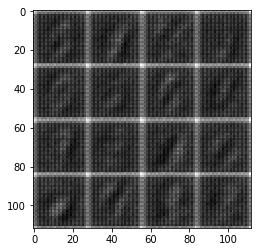

discriminator loss:  1.21621 generator loss:  1.53908
discriminator loss:  1.25209 generator loss:  1.34393
discriminator loss:  1.0823 generator loss:  1.27858


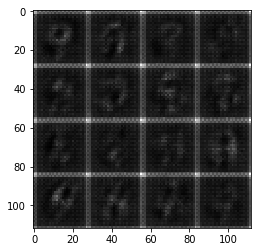

discriminator loss:  1.22327 generator loss:  0.523572
discriminator loss:  1.17591 generator loss:  1.73471


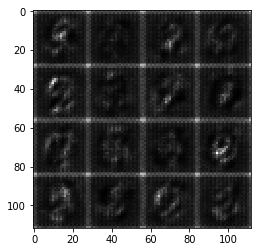

discriminator loss:  0.995543 generator loss:  0.684012
discriminator loss:  1.19156 generator loss:  2.11943
discriminator loss:  1.1228 generator loss:  2.30701


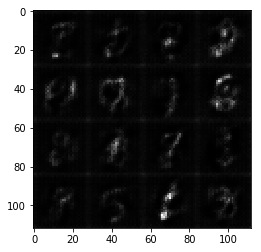

discriminator loss:  0.925181 generator loss:  1.70656
discriminator loss:  1.1012 generator loss:  2.4178


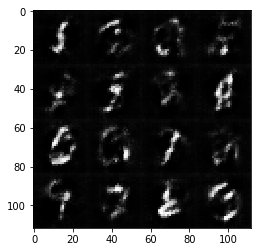

discriminator loss:  1.06911 generator loss:  1.91939
discriminator loss:  0.989848 generator loss:  0.791349
discriminator loss:  0.914704 generator loss:  0.862513


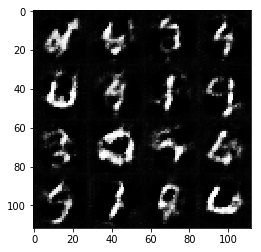

discriminator loss:  0.968629 generator loss:  1.76222
discriminator loss:  1.43926 generator loss:  0.347599


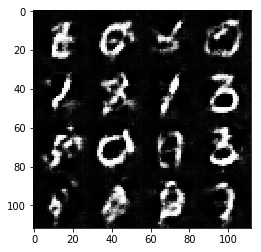

discriminator loss:  0.836978 generator loss:  1.20866
discriminator loss:  1.02823 generator loss:  0.790868
discriminator loss:  1.16474 generator loss:  0.493457


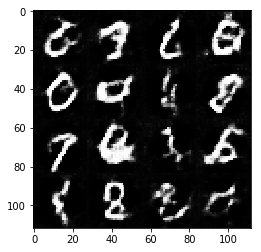

discriminator loss:  0.954131 generator loss:  1.21862
discriminator loss:  0.930158 generator loss:  1.52997


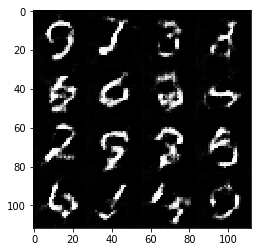

discriminator loss:  0.886324 generator loss:  1.22954


In [13]:
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

all vars found:  26
generator vars found:  14 :  ['generator/x1.dense/kernel:0', 'generator/x1.dense/bias:0', 'generator/x2.bn/beta:0', 'generator/x2.bn/gamma:0', 'generator/x3.conv2d_t/kernel:0', 'generator/x3.conv2d_t/bias:0', 'generator/x3.bn/beta:0', 'generator/x3.bn/gamma:0', 'generator/x4.conv2d_t/kernel:0', 'generator/x4.conv2d_t/bias:0', 'generator/x4.bn/beta:0', 'generator/x4.bn/gamma:0', 'generator/x5.conv2d_t/kernel:0', 'generator/x5.conv2d_t/bias:0']
discriminator vars found:  12 :  ['discriminator/x1.conv2d/kernel:0', 'discriminator/x1.conv2d/bias:0', 'discriminator/x2.conv2d/kernel:0', 'discriminator/x2.conv2d/bias:0', 'discriminator/x2.bn/beta:0', 'discriminator/x2.bn/gamma:0', 'discriminator/x3.conv2d/kernel:0', 'discriminator/x3.conv2d/bias:0', 'discriminator/x3.bn/beta:0', 'discriminator/x3.bn/gamma:0', 'discriminator/x4.dense/kernel:0', 'discriminator/x4.dense/bias:0']
discriminator loss:  0.975769 generator loss:  1.07367
discriminator loss:  1.98666 generator loss:

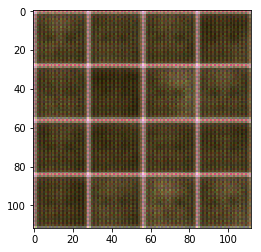

discriminator loss:  1.5012 generator loss:  0.523372
discriminator loss:  1.48969 generator loss:  0.923142
discriminator loss:  1.3218 generator loss:  0.841484


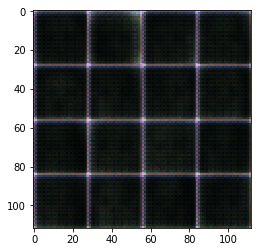

discriminator loss:  1.20664 generator loss:  0.794564
discriminator loss:  1.30773 generator loss:  0.824492


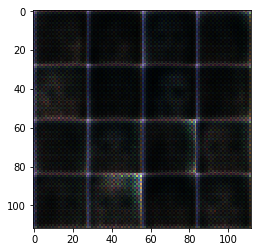

discriminator loss:  1.5258 generator loss:  0.889362
discriminator loss:  1.60747 generator loss:  0.828915
discriminator loss:  1.27474 generator loss:  1.32497


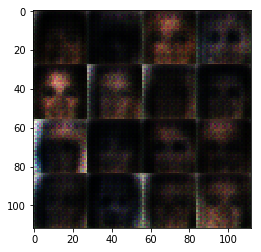

discriminator loss:  1.12391 generator loss:  0.734068
discriminator loss:  1.56641 generator loss:  0.65743


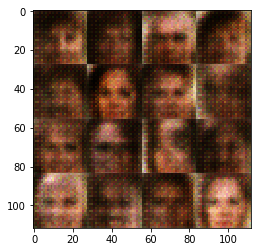

discriminator loss:  1.05775 generator loss:  1.01946
discriminator loss:  1.22206 generator loss:  0.971741
discriminator loss:  1.44715 generator loss:  1.69704


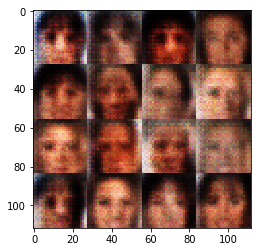

discriminator loss:  1.52646 generator loss:  0.42971
discriminator loss:  1.48046 generator loss:  0.646949


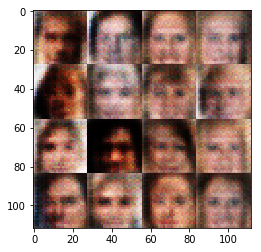

discriminator loss:  1.45573 generator loss:  0.68083
discriminator loss:  1.55865 generator loss:  0.600489
discriminator loss:  1.41374 generator loss:  0.772881


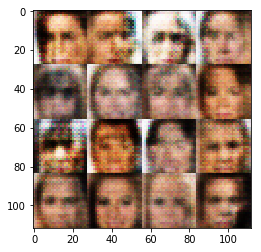

discriminator loss:  1.47357 generator loss:  0.689187
discriminator loss:  1.51456 generator loss:  0.604961


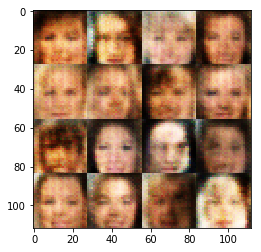

discriminator loss:  1.40563 generator loss:  0.661373
discriminator loss:  1.46666 generator loss:  0.735369
discriminator loss:  1.56673 generator loss:  0.802971


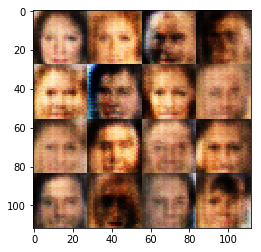

discriminator loss:  1.34042 generator loss:  0.780438
discriminator loss:  1.48228 generator loss:  0.658457


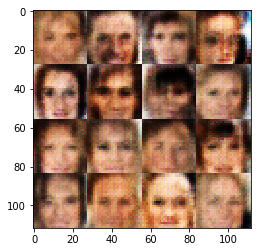

discriminator loss:  1.34053 generator loss:  0.698999
discriminator loss:  1.28287 generator loss:  0.70703
discriminator loss:  1.42016 generator loss:  0.61732


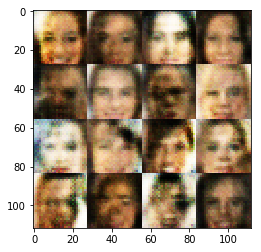

discriminator loss:  1.5671 generator loss:  0.642735
discriminator loss:  1.29746 generator loss:  0.721612


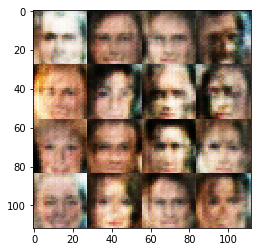

discriminator loss:  1.43065 generator loss:  0.552156
discriminator loss:  1.32492 generator loss:  0.835838
discriminator loss:  1.39978 generator loss:  0.864886


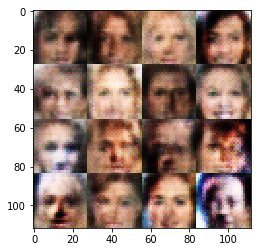

discriminator loss:  1.47352 generator loss:  0.813553
discriminator loss:  1.29011 generator loss:  0.983219


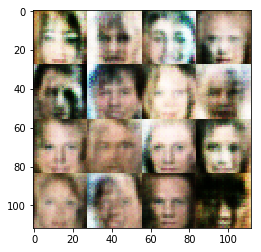

discriminator loss:  1.28082 generator loss:  0.698379
discriminator loss:  1.15048 generator loss:  0.981726
discriminator loss:  1.2329 generator loss:  0.75628


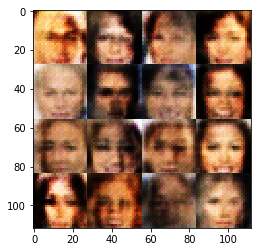

discriminator loss:  0.862819 generator loss:  1.51416
discriminator loss:  1.16304 generator loss:  0.803146


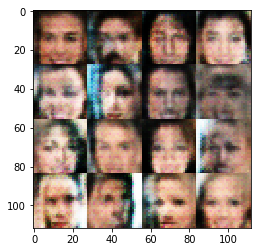

discriminator loss:  1.78107 generator loss:  0.286228
discriminator loss:  1.51919 generator loss:  1.54035
discriminator loss:  1.35964 generator loss:  0.757799


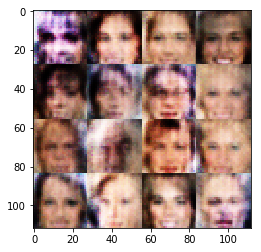

discriminator loss:  1.10769 generator loss:  1.06171
discriminator loss:  1.14648 generator loss:  0.961375


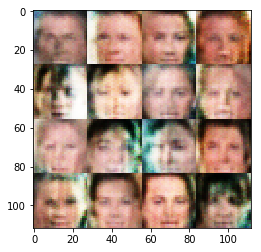

discriminator loss:  1.39547 generator loss:  0.578313
discriminator loss:  1.48433 generator loss:  0.439001
discriminator loss:  0.769384 generator loss:  1.30231


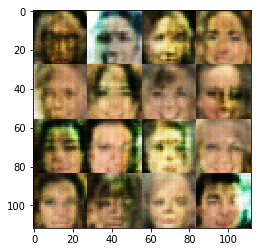

discriminator loss:  1.20522 generator loss:  0.923387
discriminator loss:  0.977937 generator loss:  2.24427


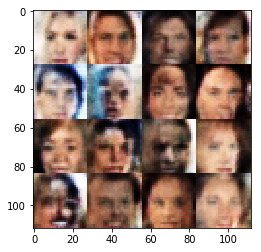

discriminator loss:  1.03045 generator loss:  1.28074
discriminator loss:  2.38721 generator loss:  0.122568
discriminator loss:  2.09016 generator loss:  0.188073


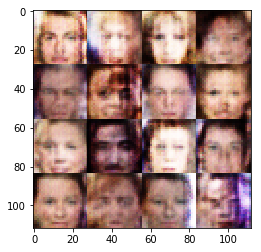

discriminator loss:  1.47986 generator loss:  0.773192
discriminator loss:  1.47477 generator loss:  0.526353


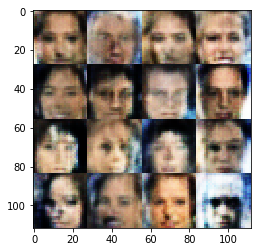

discriminator loss:  1.12075 generator loss:  1.11093
discriminator loss:  0.985119 generator loss:  1.35724
discriminator loss:  1.12611 generator loss:  1.18038


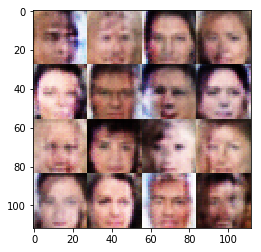

discriminator loss:  1.0198 generator loss:  1.08206
discriminator loss:  1.41106 generator loss:  2.79704


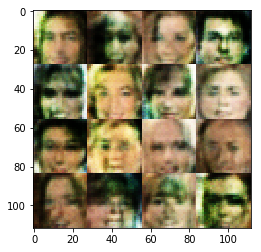

discriminator loss:  1.14699 generator loss:  0.645283
discriminator loss:  1.22538 generator loss:  1.18185
discriminator loss:  1.31845 generator loss:  0.477325


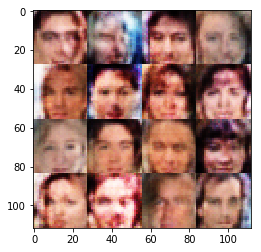

discriminator loss:  1.82474 generator loss:  0.233561
discriminator loss:  1.28331 generator loss:  0.802635


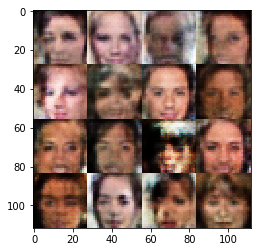

discriminator loss:  1.41612 generator loss:  1.37618
discriminator loss:  1.02334 generator loss:  1.27702
discriminator loss:  1.29117 generator loss:  0.801757


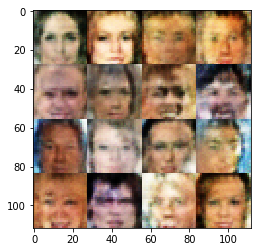

discriminator loss:  1.2614 generator loss:  0.611093
discriminator loss:  0.82483 generator loss:  1.35401


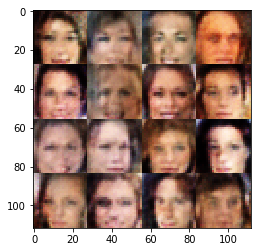

discriminator loss:  1.82547 generator loss:  0.243021
discriminator loss:  1.05167 generator loss:  0.913068
discriminator loss:  1.18327 generator loss:  0.972256


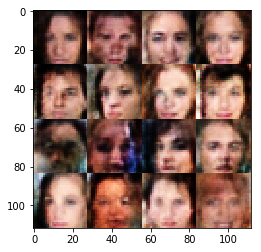

discriminator loss:  1.20122 generator loss:  0.871692
discriminator loss:  1.12071 generator loss:  0.886072


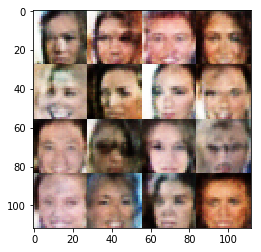

discriminator loss:  1.2477 generator loss:  0.648407
discriminator loss:  1.12792 generator loss:  1.28939


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.